# PyQC

[PyQC](https://bitbucket.org/embray/pyqc) is a project I put together specifically to make it easy to assemble and evaluate/simulate quantum circuits using a simple, terse syntax in Python--my programming language of choice.  I also wanted it to integrate with with the [IPython Notebook](http://ipython.org/notebook.html) environment; this is very similar (and in fact inspired by) the Mathematica Notebook, for those familiar with it.  This would enable users to render equations built up from objects representing quantum gates as $ \LaTeX $ equations, and to render quantum circuit diagrams.  I felt that such a tool might be of pedagogical value both for myself and others.

## Motivation and introduction to QuTiP

The idea for this project came in part from my earlier experiments with a larger Python library called [QuTiP](http://qutip.org/), which stands for Quantum Toolbox in Python.  QuTiP is designed primarily for efficient representation and evaluation of quantum operators on state vectors and simulation of complicated real world quantum systems.  It is built on a basic framework for representing operators and states in large-ish Hilbert spaces through use of "time-tested" numerical code on the backend--especially FORTRAN routines for working with sparse matrices.

I have only begun to scratch the surface of QuTiP's functionality--much of it is built to solve problems that I have not personally encountered yet, such as evaluating the time-evolution of a state vector under the influence of an arbitrary Hamiltonian.  It is not especially useful for much abstract mathematical work either, but I have occasionally found it useful to check my results numerically.  I do not want to distract too much from my own work by dwelling on QuTiP, but it would be useful to introduce some of its most basic functionality, as it underlies much of PyQC.

To get started using QuTiP, just:

In [1]:
import qutip

One could also use the `from qutip import *` which in Python means to import every object defined in the `qutip` namespace into the current local namespace.  I avoid doing that here since I want to keep it clear what functions and classes come for `qutip` as opposed to my package `pyqc`.

The central data structure underlying most of QuTiP is a class called `qutip.Qobj`.  A `Qobj` can be used to represent either a *bra/ket* state vector, *or* a quantum operator.  All of these are represented internally by sparse matrices (for example a *ket* vector is just an $ n \times 1 $ sparse matrix, while operators are $ n \times n $ where $ n $ is the size of the Hilbert space that we're operating on).  Vectors and operators can be instantiated in many different ways in QuTiP, but the simplest is just to explicitly state their elements in some basis.  For example to create a 2-dimensional *bra* vector:

In [2]:
bra = qutip.Qobj([[0, 1]])
bra

Quantum object: dims = [[1], [2]], shape = (1, 2), type = bra
Qobj data =
[[0. 1.]]

QuTiP tells us that this particular `Qobj` represents a bra (due to its shape) and displays its elements.  We can easily get the corresponding *ket* vector using the `Qobj.dag()` method:

In [3]:
ket = bra.dag()
ket

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

We can use the same syntax to create various quantum operators by specifying their matrix components (being careful to use the same basis in which we defined our state vectors).  For example we can define the Pauli matrix $ \sigma_y $ as follows (note:  Python uses the syntax `1j` to represent the imaginary unit $ i $):

In [4]:
sigma_y = qutip.Qobj([[ 0, -1j],
                      [1j,   0]])
sigma_y

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

QuTiP recognizes that being an $ n \times n $ matrix this `Qobj` represents an operator.  It also automatically makes note that it is Hermitian (it does not, however, mention whether it is unitary but non-Hermitian).  Operators can operate on a state using Python's standard multiplication operator `*`, producing a new *ket* vector:

In [5]:
sigma_y * ket

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.-1.j]
 [0.+0.j]]

I should note that many common operators are built in to QuTiP, though one of the problems I had with it early on are some of the long, relatively cumberson names they are given:

In [6]:
qutip.sigmay()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

In [7]:
qutip.identity(4)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Etc.  Sure, one could assign these operators to shorter names.  But I wanted a package that would give me a collection of short symbols that I can use out of the box to build up quantum circuits, rather than have to define them every time I need them.  To give one simple motivating example, say you wanted to create the following circuit, which implements the Deutsch algorithm for a single qubit with an oracle for the function $ f(x) = x $:

<div style="text-align: center"><img style="text-align: center" src="https://bitbucket.org/embray/pyqc/raw/a99f2387650ce253b1387b35afd09ee56e41e531/docs/source/latex/figure1.png" /></div>

To begin we want to create some $ H $ and $ \mathrm{CNOT} $ gates (and assign them reasonably short names).  Note the use of the `qutip.tensor()` function which returns the tensor product of two operators.  This also uses the `qutip.fock_dm()` (for Fock density matrix) function as a shortcut for creating outer products like $ |0\rangle\langle 0| $ and $ |1\rangle\langle 1| $:

In [8]:
H = (2 ** -0.5) * qutip.Qobj([[1, 1], [1, -1]])
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

In [9]:
CNOT = qutip.tensor(qutip.fock_dm(2, 0), qutip.identity(2)) + qutip.tensor(qutip.fock_dm(2, 1), qutip.sigmax())
CNOT

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

Then implement the circuit using a combination of multiplication operators and tensor products (returning the circuit as a new operator):

In [10]:
circuit = qutip.tensor(H, qutip.identity(2)) * CNOT * qutip.tensor(H, H)
circuit

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678  0.          0.          0.70710678]
 [ 0.70710678  0.          0.         -0.70710678]
 [ 0.          0.70710678  0.70710678  0.        ]
 [ 0.         -0.70710678  0.70710678  0.        ]]

This is fairly straightforward if you are already familiar with the circuit being implemented; but I found it difficult, just be looking at the code (without the circuit diagram) to understand what this is doing.  Now we can apply this circuit to the input $ |0\rangle |1\rangle $ by applying the circuit as an operator...

In [11]:
# Note: The basis function() returns computational basis vectors
# QuTiP is also (somewhat reasonably) very picky about vector spaces, and will not
# allow me to apply this circuit to qutip.basis(4, 1)
result = circuit * qutip.tensor(qutip.basis(2, 0), qutip.basis(2, 1))
result

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.        ]
 [ 0.70710678]
 [-0.70710678]]

...and we can use `qutip.expect()` to return the expectation value for measurements of the first qubit:

In [12]:
qutip.expect(qutip.tensor(qutip.sigmaz(), qutip.identity(2)), result)

-1.0000000000000004

This clearly gives the correct answer (ignoring floating point round-off errors), and it wasn’t terribly difficult, but still a bit cumbersome.  But to be clear, PyQC set out to be more than just a collection of shorter names for QuTiP operations.  I wanted a way to more easily create quantum circuits in a format similar to how one might draw a circuit diagram.

## Introduction to vectors and operators in PyQC

The first features of PyQC that I will introduce are not very particular to quantum information, but served as useful building blocks.  To start using PyQC one can either call `import pyqc`, or if you are not worried about cluttering the namespace it is useful to just import all of the `pyqc` module into the current namespace:

In [13]:
from pyqc import *

### Bra/ket vectors

First let me introduce the `Bra` and `Ket` classes; although they could be used for representing arbitrary state vectors, they are geared toward representing registers of qubits.  To create a single qubit just call:

In [14]:
Ket(0)

|0>

or

In [15]:
Ket(1)

|1>

Everything the `Ket` class can do, the `Bra` class can do analogously:

In [16]:
Bra(1)

<1|

Multiple qubit states can be created in one of three ways.  The `Ket` constructor can take an arbitrary number of positional arguments.  If all arguments are $ 0 $ or $ 1 $ it treats them as bits and creates the appropriate state to represent that bit string:

In [17]:
Ket(1, 0, 1)

|1, 0, 1>

Alternatively, one can provide a single integer, and a state is created that represents that integer in the smallest required number of qubits:

In [18]:
Ket(5)

|5>

It should be noted that when a `Ket` is instantiated this way, it is represented by the given integer, rather than the corresponding bit string.  There are options to change this, and it is still equivalent to the previous `Ket` instantiated with bits:

In [19]:
Ket(5) == Ket(1, 0, 1)

True

To represent an integer (say, 3) in a larger space of more than 2 qubits one can manually specify the `n_qubits=` argument.  When using this option the bit string representation is always used as it is less ambiguous (though this may not scale well with larger integers; I still have as a "todo" item to find a resolution to that problem):

In [20]:
Ket(3, n_qubits=4)

|0, 0, 1, 1>

The third way of creating a multi-qubit state is to directly take the tensor product of multiple states by using the `*` operator in Python (I will go into more detail on how PyQC objects operate with each other below):

In [21]:
Ket(1) * Ket(0) * Ket(1)

|1, 0, 1>

This would be a good point to note that underlying all of these `Bra` and `Ket` objects are QuTiP's `Qobj`.  The `Qobj` associated with each `BraKet` instance can be accessed via the `.qobj` attribute:

In [22]:
Ket(5).qobj

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

In [23]:
Bra(5).qobj

Quantum object: dims = [[1, 1, 1], [2, 2, 2]], shape = (1, 8), type = bra
Qobj data =
[[0. 0. 0. 0. 0. 1. 0. 0.]]

Finally, superpositions can be created by simple addition and subtraction.  By default, all superpositions are automatically normalized:

In [24]:
Ket(0) + Ket(1)

sqrt(1/2)(|0> + |1>)

In [25]:
Ket(0, 0) + Ket(1, 0) - Ket(1, 1)

sqrt(1/3)(|0, 0> + |1, 0> - |1, 1>)

A superposition of `Ket`s is just another `Ket` with its own underlying `Qobj`:

In [26]:
s = Ket(0, 0) + Ket(1, 0) - Ket(1, 1)
s.qobj

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.57735027]
 [ 0.        ]
 [ 0.57735027]
 [-0.57735027]]

### Operators

The `Operator` class in PyQC is currently similar to creating operators in QuTiP:  It is simply instantiated with a list of its matrix elements.  There are few restrictions on the general `Operator` class--an operator need not be Hermitian, unitary, etc.  Just an arbitrary $ n \times n $ matrix:

In [27]:
O = Operator([[1, 2],
              [3, 4]])
O

O_0 = [[1. 2.]
       [3. 4.]]

As with the `Bra` and `Ket` classes it is backed by a fully-capable `Qobj`:

In [28]:
O.qobj

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[1. 2.]
 [3. 4.]]

One thing that sets this `Operator` type apart from the basic `Qobj` class is that each operator one defines may be given a unique name:

In [29]:
O = Operator([[1, 2],
              [3, 4]], name='O')
O

O = [[1. 2.]
     [3. 4.]]

### Binary operations

One thing that sets PyQC apart from other similar packages, which may be initially confusing, is how it uses the binary operators available in the Python language.  Python has a fixed set of symbols that can be recognized by the language as binary operators between two objects, and it is not currently possible to define new ones--it is fixed by the language.  That is something I would like to see changed one day, but it is difficult under the current implementation.

Most libraries in Python, including QuTiP, use the `*` operator for multiplication-like operations between two objects (it is, after all, the operator used for multiplication of numbers).  I wanted to try something different:  Instead, I opted to the bar operator `|` (normally reserved for the logical or of two integers) to represent three types of operations: inner and outer products of vectors, and operators acting on a vector.

I feel that this is a little closer to how we actually write these operations by hand.  In quantum mechanics especially it is not common to write out an operator for multiplication-like operations, opting instead to represent it with concatenation.  Although concatenating two variables together in Python is not possible, using the `|` looks a little "closer" to concatenation.  For example, we can write $ \langle 0|0 \rangle$ like:

In [30]:
Bra(0)|Ket(0)

1.0

We can also use this to create an operator from an outer product like $ |0\rangle\langle 0| $:

In [31]:
Ket(0)|Bra(0)

O_1 = [[1. 0.]
       [0. 0.]]

This frees up the `*` operator for use as the tensor product, which is a lot nicer than having to write out something like `tensor(A, B)`:

In [32]:
A = Operator([[1, 1],
              [2, 2]], name='A')

B = Operator([[3, 3],
              [4, 4]], name='B')

A * B

A * B = [[3. 3. 3. 3.]
         [4. 4. 4. 4.]
         [6. 6. 6. 6.]
         [8. 8. 8. 8.]]

In [33]:
(A * B).display_latex(representation='both')

Note that this means we do have to use the `*` operator even when the context is unambiguous, whereas sometimes in equations the $ \otimes $ symbol can be dropped.  For example it is common to write the tensor product of two vectors like $ |0\rangle|0\rangle $.  But with PyQC it is necessary to write:

In [34]:
Ket(0)*Ket(0)

|0, 0>

As mentioned previously, the `|` operator is also used to apply an operator to a vector.  One caveat to note is that *currently* this returns a raw `qutip.Qobj`.  The reason is that numerical routines are being used to do the operation.  So as soon as we apply an operator the abstract, symbolic representation in a sense "collapses" to a purely numeric representation of the system:

In [35]:
O|Ket(0)

0.31622776601683794|0> + 0.9486832980505138|1>

This limitation *could* be subverted by carrying forward the symbolic representation alongside the numeric operations, but it would represent significant overhead for larger systems.  It was very difficult to resist the temptation to build a fully featured symbolic manipulation system on top of this.  It would be possible, but it would be reinventing the wheel.  This is discussed a little more toward the end.

## Quantum gates

Up until this point, not much of this has been particular to quantum computing.  However, there is a more specialized *subclass* of `Operator` included in PyQC called `Gate`.  A `Gate` is *required* to be unitary, and must be of size $ 2^n \times 2^n $:

In [36]:
try:
    Gate([[1, 2],
          [3, 4]])
except Exception as e:
    print(e)

Input matrix for Gate must be a 2^n x 2^n unitary:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[1. 2.]
 [3. 4.]]


In [37]:
try:
    Gate([[1, 0, 0],
          [0, 1, 0],
          [0, 0, 1]])
except Exception as e:
    print(e)

Input matrix for Gate must be a 2^n x 2^n unitary:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In fact, any `Operator` that meets these conditions is automatically "promoted" to a `Gate`:

In [38]:
G = Operator([[-1,  0],
              [ 0,  1]], name='G')
type(G)

pyqc.operator.Gate

`Gate` instances are not otherwise represented differently from general `Operator`s:

In [39]:
G

G = [[-1.  0.]
     [ 0.  1.]]

PyQC comes with several commonly used gates out of the box when performing `from pyqc import *`, for example:

In [40]:
Z

Z = [[ 1.  0.]
     [ 0. -1.]]

In [41]:
H

H = [[ 0.70710678  0.70710678]
     [ 0.70710678 -0.70710678]]

In [42]:
S  # A "todo" item is to fix up floating point rounding errors so that gates like this have a niecer representation

S = [[1.000000e+00+0.j 0.000000e+00+0.j]
     [0.000000e+00+0.j 6.123234e-17+1.j]]

In [43]:
CNOT

CNOT = [[1. 0. 0. 0.]
        [0. 1. 0. 0.]
        [0. 0. 0. 1.]
        [0. 0. 1. 0.]]

...and many others.

Gates can be used to build up circuits using the normal multiplication and tensor product operations.  Going back to the simple example from the beginning:
<div style="text-align: center"><img style="text-align: center" src="https://bitbucket.org/embray/pyqc/raw/a99f2387650ce253b1387b35afd09ee56e41e531/docs/source/latex/figure1.png" /></div>
This can be written as:

In [44]:
circuit = (H * I)|CNOT|(H * H)
circuit.display_latex('both')

In [45]:
output = circuit|Ket(0, 1)
output

sqrt(1/2)(|1, 0> - |1, 1>)

As in the pure QuTiP-based example we can still use the `qutip.expect` function to measure the first qubit by evaluating the expectation value of the operator $ \hat{Z} \otimes \hat{I} $ on the state output by the circuit:

In [46]:
qutip.expect((Z * I).qobj, output.qobj)

-1.0000000000000002

But PyQC `Gate` objects also provide a shortcut for this in the form of the `Gate.evaluate()` method:

In [47]:
circuit.evaluate(0, 1)

/home/embray/src/pyqc/pyqc/operator.py:694: UserWarning: Some qubits were left in superposition; output not deterministic.
  'Some qubits were left in superposition; output not '


|1, 0>

Recall that our circuit left the second qubit in a superposition, hence the warning.  The first qubit will always be $ |1\rangle $, but the full output will be $ |10\rangle $ 50% of the time, or $ |11\rangle $ the other 50% according to the probability distribution given be the resulting state.  An item on my "todo" list is to output exactly which qubits are non-deterministic.  Of course, we could always make this particular circuit fully deterministic (and restore the ancilla to its original state) by applying a second Hadamard gate: 

In [48]:
circuit = (I * H)|circuit
circuit.evaluate(0, 1)

|1, 1>

## Quantum circuits

We have seen how it is possible to build quantum circuits by building up algebraic expressions out of products and tensor products of quantum gates.  One of the goals of PyQC, however, was to provide a "Pythonic" syntax for writing out a quantum circuit somewhat in the same way one would draw it as a circuit diagram.  It is not unnatural to think of a circuit as a 2D array: Each row represents a "wire" in the circuit for a single qubit, while each column lists the gates operating on one or more qubits at each time step (or the single qubit identity operator for noop/"blank" wires).

PyQC currently supports a `Circuit` class which is a subclass of `Gate`, allowing circuits to be defined in such a manner. A `Circuit` object can be used in place any other `Gate` object--it can operate on state vectors and supports the `.evaluate()` method.  One other "perk" of the `Circuit` class is that it is rendered by default as a circuit diagram.  The Deutsch algorithm circuit that we have seen in other examples is defined like this:

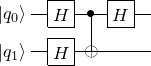

In [49]:
circuit = Circuit.from_wires(
    [H, CNOT.control, H],
    [H, CNOT.target,  I])
circuit

There are two things to note about this.  First is the way $ CNOT $ and other multi-qubit gates are expressed in the circuit definition.  Since each row in the array represents operations on a single qubit, we need a way to "split up" multi-qubit circuits across lines.  We cannot just write `CNOT` on each line, as it would be ambiguous which qubit should be the control and which should be the target.  The trick is that any `Gate` (even technically single-qubit `Gate`s) have labels on each of their inputs.  By default the labels are just `qubit0`, `qubit1`, $ \dots $, `qubit`$n$.  However when creating new `Gate`s custom labels may be assigned to each input, as we can see with `CNOT`.

The other thing to note is that the circuit does not make any mention of the measurement at the end.  There is currently no syntax for this, but that is definitely on the "todo" list, as are default/ancilla inputs and support for classical bits.  As it stands, it is still possible to obtain measurements by using the `.evaluate()` method:

In [50]:
circuit.evaluate(0, 1)

/home/embray/src/pyqc/pyqc/operator.py:694: UserWarning: Some qubits were left in superposition; output not deterministic.
  'Some qubits were left in superposition; output not '


|1, 1>

Two other features worth pointing out:  First, any existing `Gate` can be made into a controlled gate by using the `ControlledGate` wrapper:

In [51]:
CS = ControlledGate(S)
CT = ControlledGate(T)

Currently this only allows single control qubits, though it will be easy to extend to allow multiple control qubits.  Custom controlled gates automatically have the labels `.control` and `.target` for the inputs.  Controlled multi-qubit gates have the the inputs to their target gate labeled `.target0`, `.target1`, etc.

The other feature is that, as labels like `.control` and `.target` can become cumbersome in larger circuits, any label can have any number of aliases.  For example controlled gates automatically have the aliases `.c` and `.t` for their control and target inputs respectively.  Putting these features together we can easily implement a 3 qubit QFT:

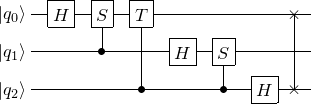

In [52]:
qft_3 = Circuit.from_wires(
    [H, CS.t, CT.t, I,   I,  I, SWAP.q0],
    [I, CS.c,   I,  H, CS.t, I, I      ],
    [I,   I,  CT.c, I, CS.c, H, SWAP.q1]
)
qft_3

I believe there is still room for improvement in this circuit definition format, but I feel like it's a good start.

I wanted to make use of this to plot the phase factors of each computational basis state under the Fourier transform.  Intuitively it was always clear to me that the QFT produces an equal superposition, as the phase factors do not contribute to the probability of each state in the superposition.  Clearly for the state $ |00\cdots 0\rangle $ each state has a phase factor of 1.  But for other inputs to QFT the result was not always as intuitively obvious to me at first.  So I defined a utility to plot an array of complex amplitudes as vectors on the complex plane:

In [53]:
# This incantation is required to enable in-line plots
%matplotlib inline

from mpl_toolkits.axisartist.axislines import SubplotZero
from matplotlib.transforms import BlendedGenericTransform
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_as_vectors(complex_nums):
    fig = plt.figure(1, figsize=(6, 6))
    ax = SubplotZero(fig, 111)
    ax.set_aspect('equal')
    fig.add_subplot(ax)
    
    # Add 'nice' labels above/next to the axes; this should be easier to do
    transform = BlendedGenericTransform(ax.transData, ax.transAxes)
    ax.text(0, 1.05, "$\Im$", transform=transform, ha='center')
    transform = BlendedGenericTransform(ax.transAxes, ax.transData)
    ax.text(1.05, 0, "$\Re$", transform=transform, va='center')
    
    for direction in ["xzero", "yzero"]:
        ax.axis[direction].set_axisline_style("-|>")
        ax.axis[direction].set_visible(True)

    for direction in ["left", "right", "bottom", "top"]:
        ax.axis[direction].set_visible(False)

    origin = np.zeros(len(complex_nums))
    ax.quiver(origin, origin, complex_nums.real, complex_nums.imag,
              angles='xy', scale_units='xy', scale=1, color='green',
              width=0.02, zorder=3)
    
    max_x = complex_nums.real.max()
    max_y = complex_nums.imag.max()
    max_xy = max(max_x, max_y)
    plt.xticks([-max_xy, max_xy])
    plt.yticks([-max_xy, max_xy])
    plt.xlim((-max_xy, max_xy))
    plt.ylim((-max_xy, max_xy))
    plt.show()

I can then obtain the amplitudes as before and plot them with this function:

In [54]:
amplitudes = qft_3|Ket(0, 0, 0)
amplitudes

sqrt(1/8)(|0, 0, 0> + |0, 0, 1> + |0, 1, 0> + |0, 1, 1> + |1, 0, 0> + |1, 0, 1> + |1, 1, 0> + |1, 1, 1>)

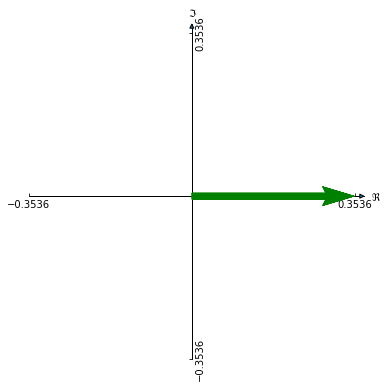

In [55]:
# The .full() method returns a non-sparse full Numpy array
plot_complex_as_vectors(amplitudes.qobj.full())

Only one arrow is shown of course because all the amplitudes are the same for the QFT on all-zeros state.  But others are more illuminating:

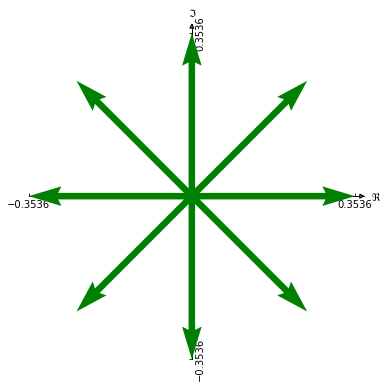

In [56]:
amplitudes = qft_3|Ket(0, 0, 1)
plot_complex_as_vectors(amplitudes.qobj.full())

The QFT on the state $ |001\rangle $ results in all $n$-th roots of unity for $ n = 8 $.  The makes sense, as in this case each coefficient of the Fourier basis state is just $ y_k = e^{2\pi ik/8} $.  This is going to be the case for any odd-numbered state.  For even numbered states the number of non-zero coefficients just alternates between 4 and 2.  More precisely, the phases are alternating between multiples of $ \pi/2 $ and $ \pi $. For $ |010\rangle $:

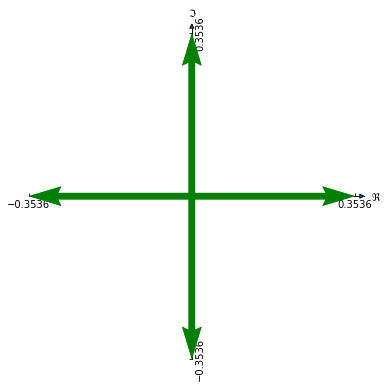

In [57]:
amplitudes = qft_3|Ket(0, 1, 0)
plot_complex_as_vectors(amplitudes.qobj.full())

...and so on...

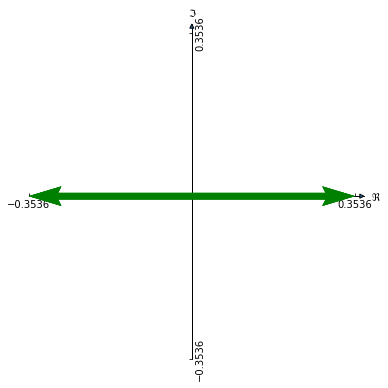

In [58]:
amplitudes = qft_3|Ket(1, 0, 0)
plot_complex_as_vectors(amplitudes.qobj.full())

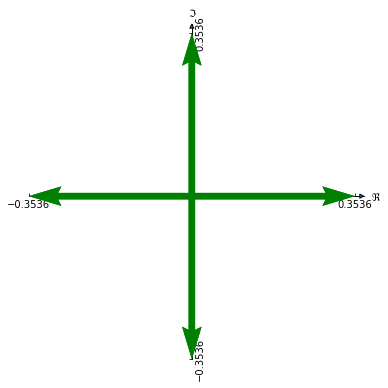

In [59]:
amplitudes = qft_3|Ket(1, 1, 0)
plot_complex_as_vectors(amplitudes.qobj.full())

We can also create circuits for QFTs on larger numbers of qubits.  PyQC includes a gate called `R_k` used in the basic construction of QFT circuits.  It is defined as:

$ R_k = \left(\matrix{1 & 0 \cr 0 & e^{2\pi i/2^k}}\right) $

This is an example of a parameterized `Gate`.  One goal of PyQC that I have not yet implemented is an interface for easily defining custom parameterized gates, but `R_k` should give a flavor of how they would work.  By default `R_k` is equivalent to $ R_0 $:

In [60]:
R_k

R_0 = [[1.+0.0000000e+00j 0.+0.0000000e+00j]
       [0.+0.0000000e+00j 1.-2.4492936e-16j]]

But the parameter can be changed by using function call notation:

In [61]:
R_k(2)

R_2 = [[1.000000e+00+0.j 0.000000e+00+0.j]
       [0.000000e+00+0.j 6.123234e-17+1.j]]

Controlled $ R_k $ gates, along with $ H $ gates form the building blocks of a QFT circuit:

In [62]:
CR_2 = ControlledGate(R_k(2))
CR_3 = ControlledGate(R_k(3))
CR_4 = ControlledGate(R_k(4))

In [63]:
qft_4 = Circuit.from_wires(
    [H, CR_2.t, CR_3.t, CR_4.t, I, I,      I,      I, I,      I, SWAP.q0, I      ],
    [I, CR_2.c, I,      I,      H, CR_2.t, CR_3.t, I, I,      I, I,       SWAP.q0],
    [I, I,      CR_3.c, I,      I, CR_2.c, I,      H, CR_2.t, I, I,       SWAP.q1],
    [I, I,      I,      CR_4.c, I, I,      CR_3.c, I, CR_2.c, H, SWAP.q1, I]
)

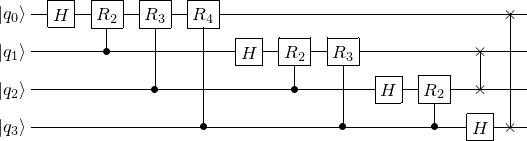

In [64]:
qft_4

As is the case for any number of qubits, the QFT on the odd-numbered basis states result in all $n$-th roots of unity being represented in the probability amplitudes: 

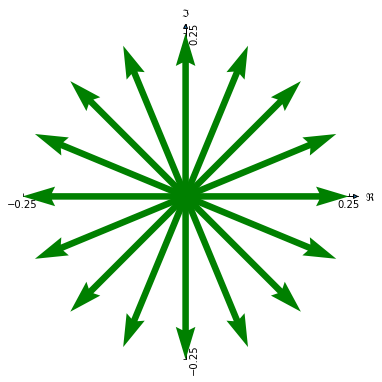

In [65]:
amplitudes = qft_4|Ket(0, 0, 0, 1)
plot_complex_as_vectors(amplitudes.qobj.full())

Inputting $ |2\rangle $ to this QFT results in phases that are multiples of $ \pi/4 $:

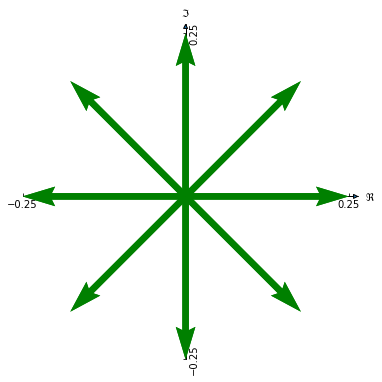

In [66]:
amplitudes = qft_4|Ket(0, 0, 1, 0)
plot_complex_as_vectors(amplitudes.qobj.full())

...and so on.

It should be easy, with these constructs, to write a function that produces a circuit for an $n$-bit QFT.  That would then serve as a jumping off point for implmenting order-finding using phase estimation (i.e. Shor's algorithm).  That would be where I would have gone next with a little more time.

## Known issues and shortcomings

Some of the known unresolved issues with PyQC have already been discussed.  One of the main issues is awkward way it straddles symbolic manipulation and numerical calculations, in particular once an operator is applied to a state.  While for most real applications the numerical calculations are more useful, but the loss of the abstract symbolic representation has less pedagogical value in my opinion.  I will have a little more to say on that in the conclusion.

Another major issue is that some routines are much less efficient than they can or should be, even despite the use of QuTiP and SciPy's numerical routines.  Much of this has to do with superfluous calculation of intermediate results that are not needed in the final result, in particular when it comes to combining operators in a circuit.  Much of the code is still in a "prototype" state in that it gets the job done correctly but naïvely.  There is a wealth of reasearch that would be worth going into, for example, on simplifying and optimizing various constructions in quantum circuits.  The `Circuit` class could be used like a compiler--given a simpler, human-readable description of the circuit it could employ any number of optimization tricks in building up the actual matrix representation of the circuit.

Other known issues are missing features such as better support for measurement and classical bits in circuits; thse could be implemented with more time.  Support for muliple control gates can be added with a few tweaks to the existing `ControlledGate` class.  Another is lack of support for non-equal superpositions of states--it is not currently possible to give arbitrary weights to states in a superposition.  Much of the infrastructure is in place to support that, the need just has not arisen.

One issue that I did not mention yet is the issue of order of operations.  In addition to the set of available operator symbols being fixed in Python, the order of operations for those symbols is also fixed--hard-coded in the language.  For example, in an expression like `a * b + c`, the `*` operation is always evaluated before the `+`.  With the syntax I have adopted for multiplication and tensor products, an expression like `A * B|C` *should* be grouped like $ A \otimes (BC) $ and *not* like $ (A \otimes B)C $.  The good news is that we can infer the intended order of operations by the dimensions of the operands in such expression.  If $ B $ and $ C $ are the same dimension then is most likely `A * (B|C)` is intended rather than `(A * B)|C` which would be invalid.  Even if Python uses the wrong order of evaluation, PyQC can circumvent this through its underlying expression tree. 

There is also a minor issue with the LaTeX display of superpositions, in that the normalization factor is always written with a square root symbol, even when the number of states is square.  For example:

In [67]:
Ket(0, 0) + Ket(0, 1) + Ket(1, 0) + Ket(1, 1)

sqrt(1/4)(|0, 0> + |0, 1> + |1, 0> + |1, 1>)

This is easy enough to fix, though ironically a general solution for simplifying the square root requires a factoring algorithm.

## Conclusions

The previous example of square root simplification is a good segue back to the point I made early on, that it was difficult to resist the temptation to implement a full-blown symbolic algebra system for operators, vectors, and their coefficients.  In particular, I was aware starting out that some of this work has already been done by the [SymPy](http://docs.sympy.org/latest/modules/physics/quantum/index.html) project, which is the premier symbolic mathematics library for Python.  What I was not aware of is that SymPy also has a fledgling submodule for quantum computing work which includes a `Gate` class not too dissimilar to mine, and some early work on a pure Python implementation of quantum circuit diagrams using [matplotlib](http://matplotlib.org/).

It might be worth investigating how I can leverage the work already done in SymPy, either by contributing new code directly to the SymPy project or trying to build on top of it.  Although I have not worked closely with it yet, SymPy's quantum module does appear to have some shortcomings of its own:  It has the same problems of verbosity that I found with QuTiP.  For example to take the tensor product of two operators one has to write out `TensorProduct(A, B)`.  The documentation is still a bit light.  And most importantly it is still primarily geared toward symbolic manipulation and *not* number crunching--it does not have as efficient numerical algorithms backing it that something like QuTiP does.  That said, it is worth giving a closer look.  In particular it would be very nice to have pure Python circuit diagrams, rather than having to call out to LaTeX to generate them.  SymPy's circuit diagram implementation is still in the very early stages of development and less capable even than PyQC's, but it might be worth contributing to.

There are a handful of other basic quantum mechanics libraries for Python.  But none have the level of sophistication, documentation, and institutional support that QuTiP has.  So I am confident in my decision to build my own work on top of QuTiP.  SymPy is also probably worth giving a closer look for the problems it has already solved in symbolic manipulation.  But neither package alone has quite the balance of simplicity and power that I am trying to achieve with PyQC, so I believe it may have a place in Python quantum ecosystem.